In [1]:
import pandas as pd
import scanpy as sc
import os
import anndata as ad
os.chdir('../')
datasets = pd.read_csv('resources/datasets/meta/filtered_datasets.csv')

Choose two sets to harmonize/merge and load:

In [2]:
# get pre-processed datasets
ds1 = sc.read('resources/datasets/data/AdamsonWeissman2016_GSM2406675_10X001.h5ad')
ds2 = sc.read('resources/datasets/data/DatlingerBock2021.h5ad')
ds3 = sc.read('resources/datasets/data/TianKampmann2021_CRISPRa.h5ad')

2. Merge datasets

In [3]:
# define map of datasets to be merged, reduce to hvgs
ds_map = {
    'AdamsonWeissman2016_GSM2406675_10X001': ds1,
    'TianKampmann2021_CRISPRa.h5ad': ds3
}

In [3]:
pool = pd.read_csv('results/qc:True;scale:True;n_hvg:10000;subset_hvg:False;hvg:True;zero_padding:False;correction_method:skip/hvg_pool.csv', index_col=0)

In [4]:
def _filter(d, dataset_name, hvg_pool, zero_pad=True):
    # filter for pool of highly variable genes
    matching_hvgs = d.var_names.intersection(hvg_pool)
    print(f'Found {len(matching_hvgs)} pool genes in {dataset_name}')
    d = d[:, matching_hvgs]
    # check for missing genes
    missing_hvgs = set(hvg_pool) - set(matching_hvgs)
    if zero_pad and len(missing_hvgs) > 0:
        print(f'{len(missing_hvgs)} hvgs missing from pool; padding with zero values')
        # build zero matrix for missing genes
        zero_matrix = np.zeros((d.n_obs, len(missing_hvgs)))
        # define AnnData for missing genes
        ds_zeros = ad.AnnData(X=zero_matrix, var=pd.DataFrame(index=list(missing_hvgs)), obs=d.obs)
        # merge original and zero AnnData, keep original meta data for samples
        d = ad.concat([d, ds_zeros], axis=1, merge='first')
    else:
        print(f'{len(missing_hvgs)} hvgs lost from pool')
    return d


def _read_datasets(data_files, pool, hvg_filter=True, zero_pad=True):
    ds_dict = {}
    for file in data_files:
        if file.endswith('.h5ad'):
            print('Reading {}'.format(file))
            name = ''.join(os.path.basename(file).split('.')[:-1])
            adata = ad.read(file)
            # make cell barcodes unique to dataset
            adata.obs_names = adata.obs_names + ';' + name
            # apply hvg pool and zero-pad filters to dataset
            if hvg_filter:
                adata = _filter(adata, name, pool, zero_pad=zero_pad)
            # save dataset in dictionary
            ds_dict[name] = adata
    print(f'Finished reading {len(ds_dict)} datasets')
    return ds_dict

In [5]:
input_dir = 'resources/datasets/data'
data_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)[:2]] 

In [6]:
ds_dict = _read_datasets(data_files, pool.index, hvg_filter=True, zero_pad=False)

Reading resources/datasets/data/DatlingerBock2021.h5ad
Found 18393 pool genes in DatlingerBock2021
19543 hvgs lost from pool
Reading resources/datasets/data/AdamsonWeissman2016_GSM2406677_10X005.h5ad
Found 30891 pool genes in AdamsonWeissman2016_GSM2406677_10X005
7045 hvgs lost from pool
Finished reading 2 datasets


In [10]:
# reduce datasets to common genes
ds_list = [*ds_dict.values()]
keys = [*ds_dict.keys()]
common_genes = list(set.intersection(*(set(adata.var_names) for adata in ds_list)))
print(len(common_genes))
ds_list = [d[:10000, common_genes[:3000]] for d in ds_list]

16124


In [9]:
import scanorama
corrected_data = scanorama.correct_scanpy(ds_list)

ERROR: Data sets must be numpy array or scipy.sparse.csr_matrix, received type <class 'anndata._core.views.SparseCSCView'>.


SystemExit: 1

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [96]:
merged = ad.concat(corrected_data, label='dataset', keys=keys)

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


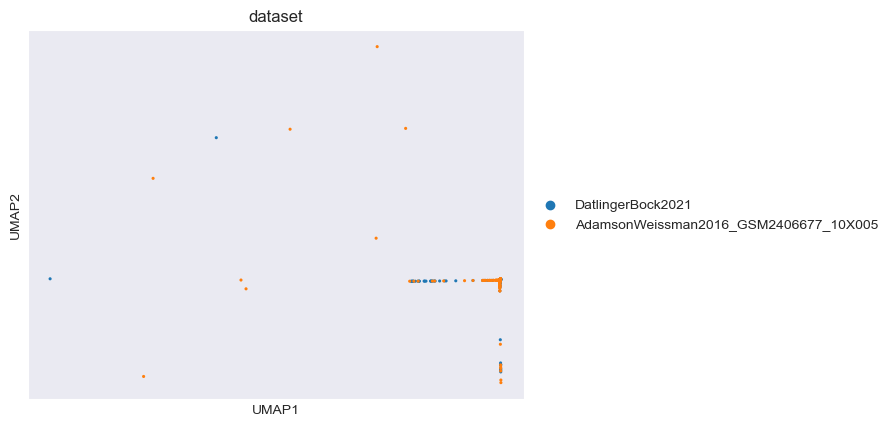

In [98]:
# Perform PCA for visualization
sc.pp.pca(merged)
# Visualize the batches in PCA space
sc.pp.neighbors(merged, use_rep='X_pca')
sc.tl.umap(merged)
sc.pl.umap(merged, color='dataset')

Visualize merged set without harmonization

3. Harmonize / batch effect correction
3.1 Harmonypy

In [264]:
metaset = sc.read('results/qc:True;n_hvg:10000;subset_hvg:False;hvg:True;zero_padding:True;correction_method:skip/perturb_metaset.h5ad')

In [20]:
scaled_metaset = sc.read('results/qc:True;scale:True;n_hvg:10000;subset_hvg:False;hvg:True;zero_padding:False;correction_method:skip/perturb_metaset.h5ad')

In [21]:
scaled_metaset

AnnData object with n_obs × n_vars = 55409 × 15794
    obs: 'cell_line', 'perturbation', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'dataset'
    var: 'ensembl_id', 'hb', 'highly_variable', 'mt', 'ribo', 'dispersions', 'dispersions_norm', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'n_cells_by_counts', 'ncells', 'ncounts', 'pct_dropout_by_counts', 'total_counts'

In [22]:
test = scaled_metaset.copy()

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8

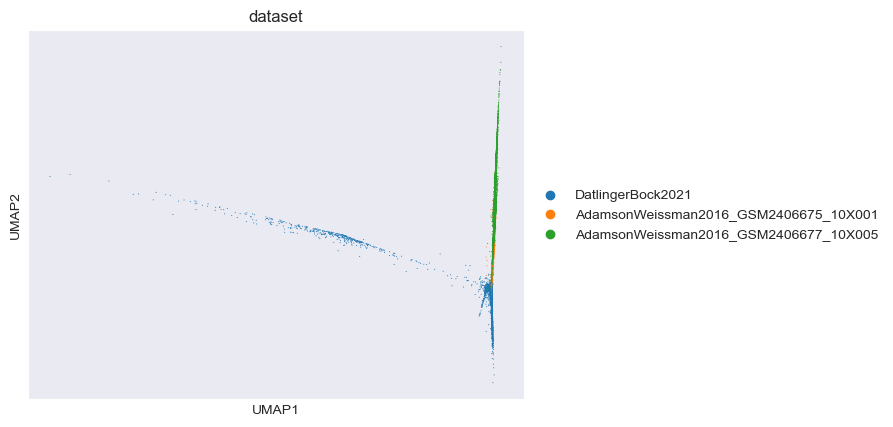

In [23]:
# Perform PCA for visualization
sc.pp.pca(test)
# Visualize the batches in PCA space
sc.pp.neighbors(test, use_rep='X_pca')
sc.tl.umap(test)
sc.pl.umap(test, color='dataset')

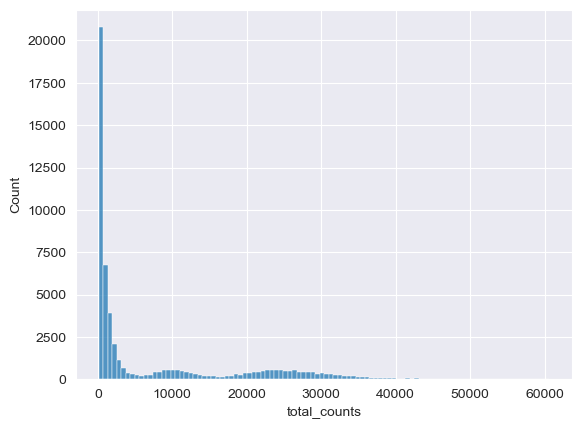

In [24]:
import seaborn as sns
import numpy as np
p3 = sns.histplot(test.obs["total_counts"], bins=100, kde=False)

In [25]:
test.obs['scaled_total_counts'] = np.array(test.X.sum(axis=1)).flatten()

Apply scaling and centering to each dataset

<AxesSubplot: xlabel='log1p_total_counts', ylabel='Count'>

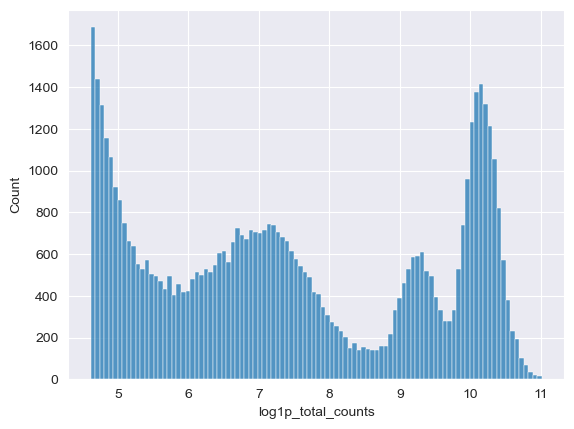

In [26]:
# Without scaling each dataset before merge
sns.histplot(test.obs['log1p_total_counts'], bins=100, kde=False)

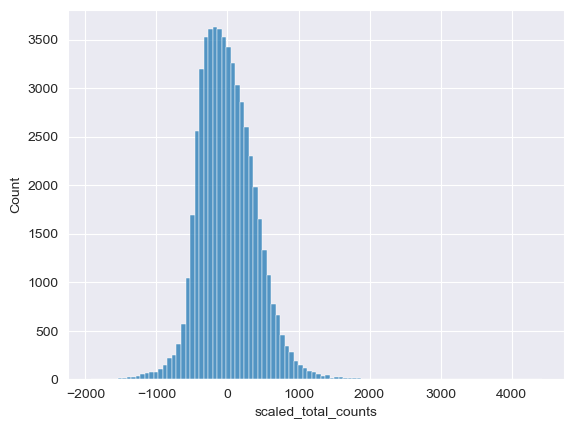

In [27]:
# With scaling and centering of each dataset before merge
p2 = sns.histplot(test.obs['scaled_total_counts'], bins=100, kde=False)

But, counts are a bit tight, try to transform and smoothen a bit

In [291]:
# tanh scaling
test.layers['tanh'] = np.tanh(test.X)

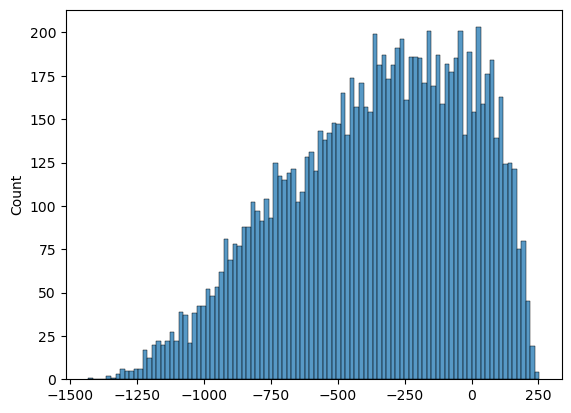

In [293]:
sns.histplot(np.array(test.layers['tanh'].sum(axis=1)).flatten(), bins=100, kde=False)

<AxesSubplot: ylabel='Count'>

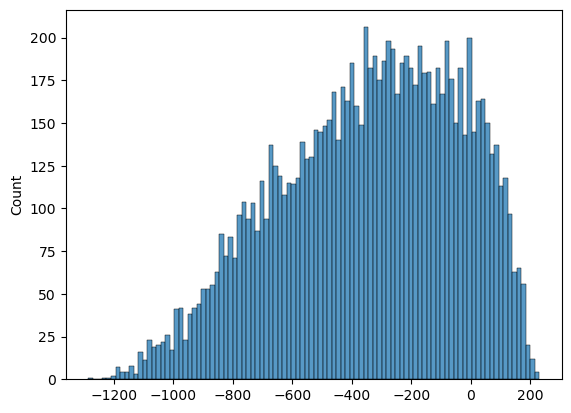

In [294]:
# Apply an exponential scaling (soft thresholding)
test.layers['scaled_log'] = np.sign(test.X) * np.log1p(np.abs(test.X))
sns.histplot(np.array(test.layers['scaled_log'].sum(axis=1)).flatten(), bins=100, kde=False)

<AxesSubplot: ylabel='Count'>

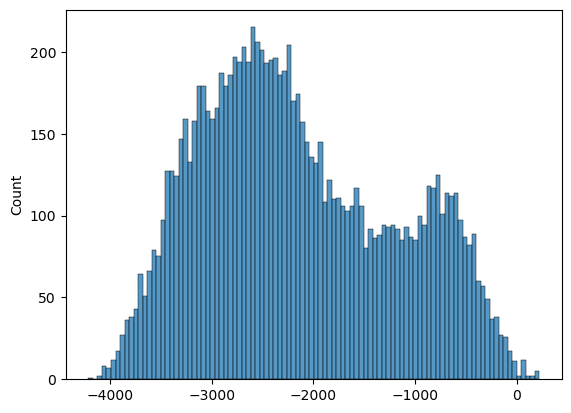

In [295]:
# Square root transformation to smooth out spiky values
test.layers['scaled_square'] = np.sign(test.X) * np.sqrt(np.abs(test.X))
sns.histplot(np.array(test.layers['scaled_square'].sum(axis=1)).flatten(), bins=100, kde=False)

Smoothing options transform data too much, generate multiple peaks, or have too many outliers, etc.
--> stick to regular scaled X